 # Audio segmentation and sorting based on similarity using MFCCs

**Mel frequency cepstral coefficients** (MFCCs) are a set of audio features which concisely describe the overall shape of a spectral envelope.

Calculating them usually goes as follows:

1. Fourier Transform is applied to the signal being analysed. This would be enough to represent some information about the frequency content of the sound, but it has several problems, ie. frequency bins are spaced linearly hence they do not match the way we hear.

2. Spectrum is mapped onto the [mel scale](https://en.wikipedia.org/wiki/Mel_scale) by filtering its bins into frequency bands that approximate a more human way of perceiving pitch.

3. Logarithm of each band is calculated - this is motivated by the fact that humans interpret loudness not linearly, but logarithmically.

4. Finally, a Discrete Cosine Transform is applied, resulting in what is called a *cepstrum* - a spectrum of a spectrum calculated in the step 1. Amplitudes of it are our MFCC values.

Thanks to the above steps, MFCCs can represent the changes of timbre in an efficient and perceptually-accurate way.

**In this notebook we will segment and analyse audio with librosa.
Then, we can use the calculated MFCCs to reorder the audio frames according to their similarity.
This will be done with scipy using k-d trees and hierarchical clustering.
As our example material we will use an excerpt from *Pulse X*, Youngsta.**

*Note: This script converts the input to mono while loading the file, averaging or calculating features for each channel separately is for now beyond the scope of this project.*


### SETUP

First of all, let's import necessary libraries:

In [26]:
import numpy as np, matplotlib.pyplot as plt, librosa, librosa.display, IPython.display as ipd, soundfile as sf, scipy.spatial, scipy.ndimage as ndi, sklearn, random
from scipy.cluster import hierarchy

Then, let's set global parameters.
It's a good idea to try modifying some of them, especially if whole tracks are used as input.

In [27]:
### PARAMETERS
plt.rcParams["figure.figsize"] = (14,10) # adjust size of plots

N_MFCC = 13 # number of MFCC coeficcients
FRAME_LENGTH = N_FFT = 2**10 # calculations can get quite slow with values below 2**11=2048
ZEROTH_FEATURE = True # 0th MFCC feature represents the average log-energy of the input signal, hence depends on loudness, not timbre
ONSET_DETECTION = True # onset detection mode
WINDOWING = True # apply hamming window to frames before analysis
SMOOTHING = True # apply custom smooth concatenate function when producing audio output
SM_WIDTH = int(FRAME_LENGTH / 2**2) # width of smoothing window
SIGMA = 7 # sigma parameter of the gauss filter used for smoothing
if ONSET_DETECTION:
    HOP_LENGTH = 2**10 # not more than 2**11, onset detection returns an empty array otherwise
else:
    HOP_LENGTH = FRAME_LENGTH

Now, let's load an audio file:

In [28]:
# if 'google.colab' in str(get_ipython()): # check if running on colab to pick the right interface for uploading files
#     print('Running on Colab')
#     from google.colab import files
#
#     uploaded = files.upload()
#
#     for fn in uploaded.keys():
#         print('User uploaded file "{name}" with length {length} bytes'.format(
#             name=fn, length=len(uploaded[fn])))
#         file = fn
# else:
#     print('Not running on Colab')
#     from ipyfilechooser import FileChooser
#
#     # Create and display a FileChooser widget
#     fc = FileChooser('.')
#     # Set a file filter patern
#     fc.filter_pattern = ['*.wav', '*.mp3', '*.flac']
#     display(fc)

In [29]:
# if not 'google.colab' in str(get_ipython()):
#     file = fc.selected
# print(file)

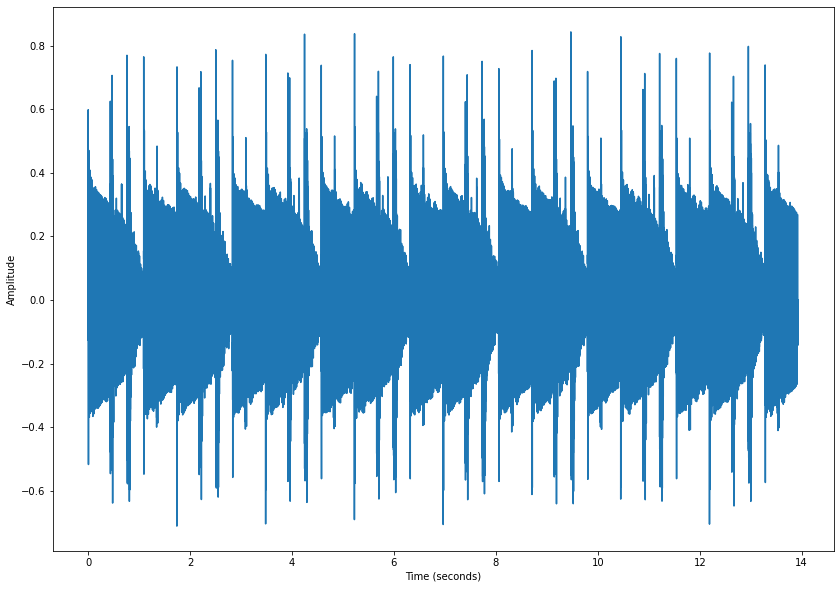

In [51]:
y, sr = librosa.load("pulse x (excerpt).wav") # load the audio file

t = np.arange(0, len(y)/sr, 1/sr) # time in seconds

plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.plot(t, y) # plot amplitude of the input against time

ipd.Audio(y, rate=sr) # play audio file using ipython display

|Now, let's start processing the audio we have loaded.
First of all, we will **segment the audio file**.
Optionally, we can use **onset detection** to slice the audio file right before each transient:

In [31]:
# segmentation at onsets
# based on: https://musicinformationretrieval.com/onset_detection.html
if ONSET_DETECTION:
    onset_frames = librosa.onset.onset_detect(y, sr=sr, backtrack=True) # detect onsets, backtrack right before them
    onset_times = librosa.frames_to_time(onset_frames, sr=sr) # convert detected frames to time
    onset_samples = librosa.frames_to_samples(onset_frames) # convert detected frames to samples
    frames = []
    for i in range(0, len(onset_samples)):
        start = onset_samples[i] # set starting sample of the frame we will create
        if i + 1 < len(onset_samples): # unless at the last frame,
            end = onset_samples[i + 1] # set first sample of the next frame as last of the current frame
        else:
            end = len(y)-1 # set end of the file as end of the last frame
        frame = (y[start:end]) # collect all samples within the frame
        if len(frame) > 0:
            frames.append(frame) # add to results
# basic segmentation
# https://musicinformationretrieval.com/segmentation.html
else:
    frames = librosa.util.frame(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T

/var/folders/kt/3yzrdbd548lfc1w4yd4phlwm0000gn/T/ipykernel_44874/1072099488.py:4: FutureWarning: Pass y=[-0.00544133 -0.01799846 -0.03146303 ... -0.02070654 -0.02148659
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  onset_frames = librosa.onset.onset_detect(y, sr=sr, backtrack=True) # detect onsets, backtrack right before them


Let's visualise how the input got segmented on top of a spectrogram,
(might look dense with longer audio files):

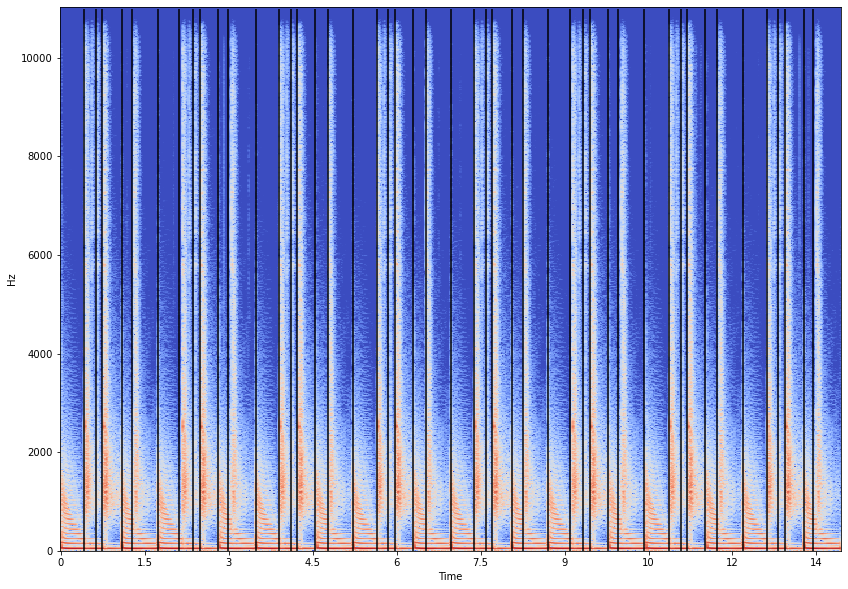

In [32]:
S = librosa.stft(y) # calculate a spectrogram of the audio
logS = librosa.amplitude_to_db(np.abs(S)) # scale amplitudes logarithmically
librosa.display.specshow(logS, sr=sr, x_axis='time', y_axis='fft') # display spectrogram
if ONSET_DETECTION:
    plt.vlines(onset_times, 0, 11000, color='k') # display onset markers
else:
    # get first sample in each frame
    slice_samples = []
    for i in range(len(frames[0]), len(frames) * len(frames[0]), len(frames[0])):
        slice_samples.append(i)
    np.array(slice_samples)
    slice_times = librosa.samples_to_time(slice_samples, sr=sr) # convert to time
    plt.vlines(slice_times, 0, 11000, color='k') # display slice markers

We can use windowing to improve the performance of our spectral analysis:

In [33]:
# apply window to segmented input
def applyWindow(frames, onset_detection):
    w_frames = []
    if onset_detection:
        for frame in frames: # window length calculated for each frame separately
            window = np.blackman(len(frame))
            w_frames.append(frame * window) # scale the frame values by the window values
    else:
        window = np.blackman(len(frames[0])) # window to use, one size fits all
        w_frames = frames * window # scale the frame values by the window values
    return w_frames # return windowed frames

Let's plot a random frame with the window applied:

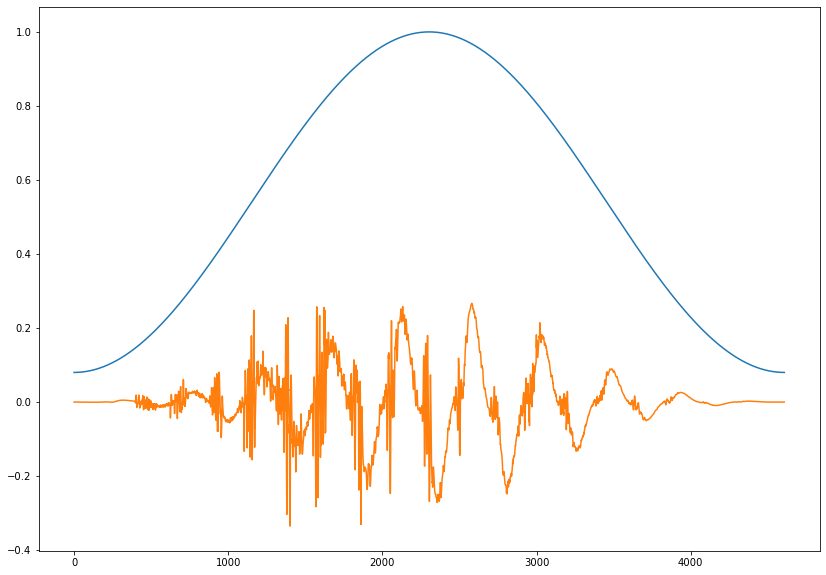

In [34]:
if WINDOWING:
    w_frames = applyWindow(frames=frames, onset_detection=ONSET_DETECTION) # apply window to frames
    r = random.randint(0, len(w_frames)-1) # get random index
    if ONSET_DETECTION:
        window = np.hamming(len(w_frames[r])) # appropriate window length for the picked frame
    else:
        window = np.hamming(FRAME_LENGTH)
    plt.plot(window) # plot window shape
    plt.plot(w_frames[r]) # plot windowed frame

Now that we have done segmentation (and windowing!) by ourselves, we can add a shorthand function for calculating MFCCs of a whole segment without the same work being done again by librosa:

In [35]:
# MFCC shorthand
def mfcc(y):
    length = len(y)  # hop length equals length of the segment so it's analysed all at once
    return librosa.feature.mfcc(y=y, sr=sr, hop_length=length, n_mfcc=N_MFCC, center=False, n_fft=N_FFT)

Then, we can use it to implement basic sliding window MFCC analysis:

In [36]:
# calculate MFCCs of pre-segmented signal
def slideMFCC(frames, zeroth_feature):
    if not zeroth_feature:
        dim = N_MFCC-1
    else:
        dim = N_MFCC
    results = np.empty((1, dim, 1))
    for frame in frames: # calculate mfcc of each frame
        next_result = mfcc(frame)
        if not zeroth_feature: # 0th feature can be enabled to take loudness into account
            next_result = next_result[1:len(next_result)]
        results = np.concatenate([results, [next_result]]) # store results together ordered accordingly
    results = results.squeeze(2)
    results = sklearn.preprocessing.scale(results, axis=1) # standardise the results
    print(results.shape) # print shape of the resulting array
    return results

In [37]:
# display calculated MFCCs
def displayMFCCS(mfccs, zeroth_feature):
    if not zeroth_feature: # adjust the y axis labels accordingly
        mfcc_i = np.arange(1, N_MFCC)
        ypos = np.arange(0, N_MFCC-1)
    else:
        mfcc_i = np.arange(0, N_MFCC)
        ypos = np.arange(0, N_MFCC)

    plt.yticks(ypos, mfcc_i)
    plt.ylabel('MFCC Coefficient Index')
    plt.xlabel('Frame Index')
    return plt.imshow(mfccs.T, origin='lower', aspect='auto', interpolation='nearest')

Now we can use the above functions to **calculate the MFCCs** of our frames:

(48, 13)


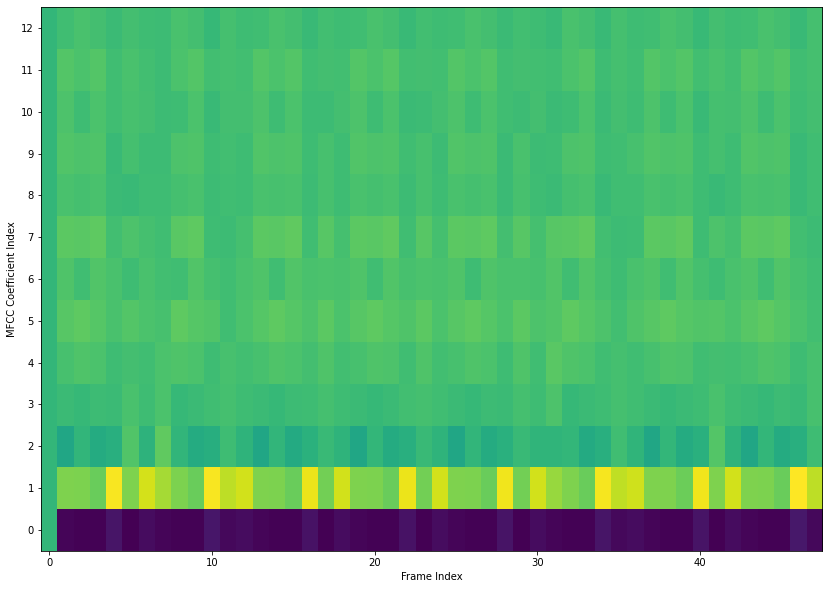

In [38]:
if WINDOWING:
    mfccs = slideMFCC(frames=w_frames, zeroth_feature=ZEROTH_FEATURE)
else:
    mfccs = slideMFCC(frames=frames, zeroth_feature=ZEROTH_FEATURE)
displayMFCCS(mfccs=mfccs, zeroth_feature=ZEROTH_FEATURE)

What can be done with the features we have calculated? Let's see.
The most simple way of using the MFCC values would be to treat the value of each coefficient as a coordinate so that distances between each frame can be calculated.

### Nearest neighbours


For example, we could find the nearest neighbours of the given frame.
We could implement our search by hand quite easily using the [euclidean distance formula](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html), but using a [k-d tree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html) structure is cleaner to program, which will become handy later.
We will use frame[0] for demonstration purposes, but querying an ordered list of nearest neighbours of any frame is very straightforward:

In [39]:
# construct a k-d tree out of mfcc frames
kdtree = scipy.spatial.KDTree(mfccs[0:len(mfccs)-1], compact_nodes=True, copy_data=False, balanced_tree=True, boxsize=None)
neighbours = kdtree.query(mfccs[0], len(mfccs)-1) # query for all existing neighbours of
# neighbours

Now it should be fairly simple to reorder the frames according to their distance from frame[0].
If we simply put them together, this will no doubt result audible clicks when we jump from one frame to another.
To avoid that, we can define a custom concatenate function that will smooth out the discontinuities with a gaussian filter over a given number of frames from each side.

In [40]:
def smoothcatenate(x, y, width, sigma):
    # print(x, y)
    li = len(x) - width
    ri = width
    # print(li, ri)
    left = x[li:len(x)]
    right = y[0:ri]
    sm = np.concatenate([left, right])
    # print(sm)
    sm = ndi.gaussian_filter1d(sm, sigma)
    # print(sm)
    result = np.concatenate([x[0:li], sm, y[ri:len(y)]])
    # print(result)
    return result

In [41]:
output = []
for neighbour in neighbours[1]:
    if SMOOTHING:
        # concat with smoothing
        output = smoothcatenate(output, frames[neighbour], width=SM_WIDTH, sigma=SIGMA)
    else:
        # concat without smoothing (will result in clicks)
        output = np.concatenate([output, frames[neighbour]])

ipd.Audio(output, rate=sr) # play audio using ipython display

Let's see how the MFCC of the output looks like:

(292, 13)


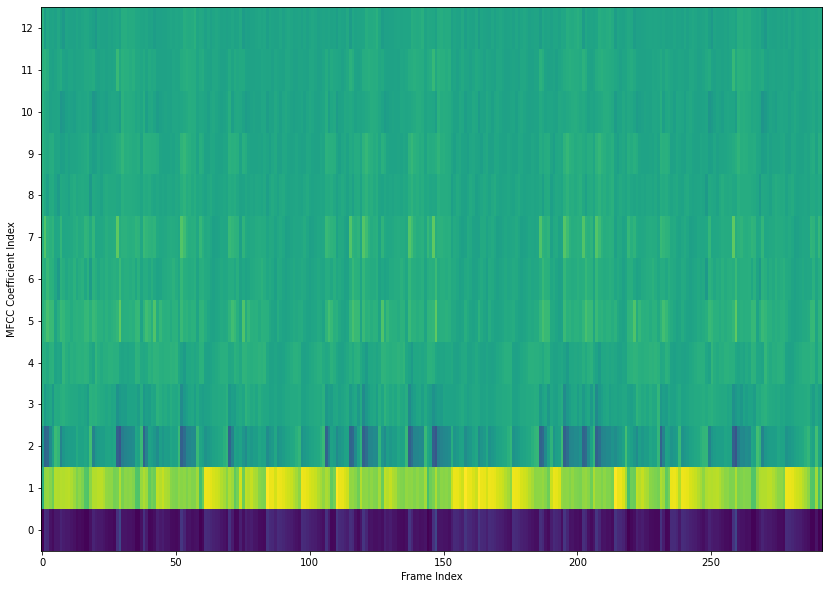

In [42]:
frames_0 = librosa.util.frame(output, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T
if WINDOWING:
    frames_0 = applyWindow(frames=frames_0, onset_detection=ONSET_DETECTION)
mfccs_0 = slideMFCC(frames=frames_0, zeroth_feature=ZEROTH_FEATURE)
displayMFCCS(mfccs=mfccs_0, zeroth_feature=ZEROTH_FEATURE)

### Shortest path

Another option is to always look for the next closest neighbour from the current frame so the result sounds shifts more smoothly.
This will require many more queries, thus will be also more performance heavy.

We will try to find the shortest path through our tree, again starting from the frame[0].
First two nodes (frames) to visit are easy to pick, it will be frame[0] and its first closest neighbour which is not itself:

In [43]:
neighbours = kdtree.query(mfccs[0], 2) # get two closest neighbours
path = neighbours[1] # start route from the two first indices
path

array([ 0, 10])

Now, we have to go to the last visited frame and check for its first closest neighbour that has not been visited yet:

In [44]:
while len(path) < len(frames): # end the loop if all nodes have been visited
    k = 2 # find k-nearest neighbours, can start with 2 since for k=1 its always the node itself
    current = mfccs[path[-1]] # current node is the last one visited
    next = kdtree.query(current, k)[1] # index of the next closest node
    while next[-1] in path:
        k += 1 # increase k if the k-th neighbour has been already visited
        next = kdtree.query(current, k)[1] # query again
    path = np.append(path, next[-1]) # mark node as visited

# path

In [45]:
output = []
for i in range(len(frames)):
    next = path[i]
    if SMOOTHING:
        output = smoothcatenate(output, frames[next], width=SM_WIDTH, sigma=SIGMA)
    else:
        output = np.concatenate([output, frames[next]])

ipd.Audio(output, rate=sr)

We can have a look at the MFCCs which should be more continuous than in the previous case:

(292, 13)


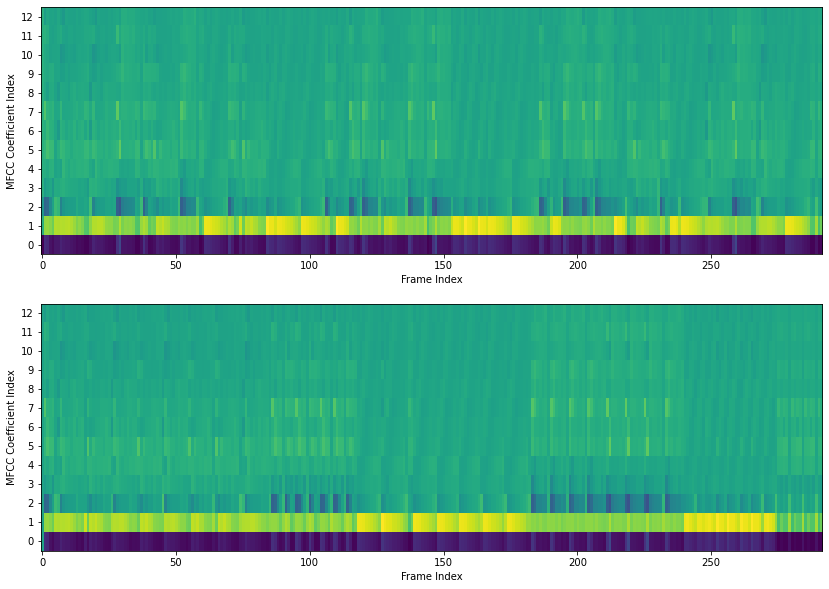

In [46]:
frames_1 = librosa.util.frame(output, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T
if WINDOWING:
    frames_1 = applyWindow(frames=frames_1, onset_detection=ONSET_DETECTION)
mfccs_1 = slideMFCC(frames=frames_1, zeroth_feature=ZEROTH_FEATURE)

plt.subplot(2, 1, 1)
displayMFCCS(mfccs=mfccs_0, zeroth_feature=ZEROTH_FEATURE)
plt.subplot(2, 1, 2)
displayMFCCS(mfccs=mfccs_1, zeroth_feature=ZEROTH_FEATURE)

### Correlation Clustering

Instead of using a k-d tree we can also cluster the analysed frames based on correlation and represent the cluster hierarchy with a [dendrogram](https://www.nonlinear.com/support/progenesis/comet/faq/v2.0/dendrogram.aspx):

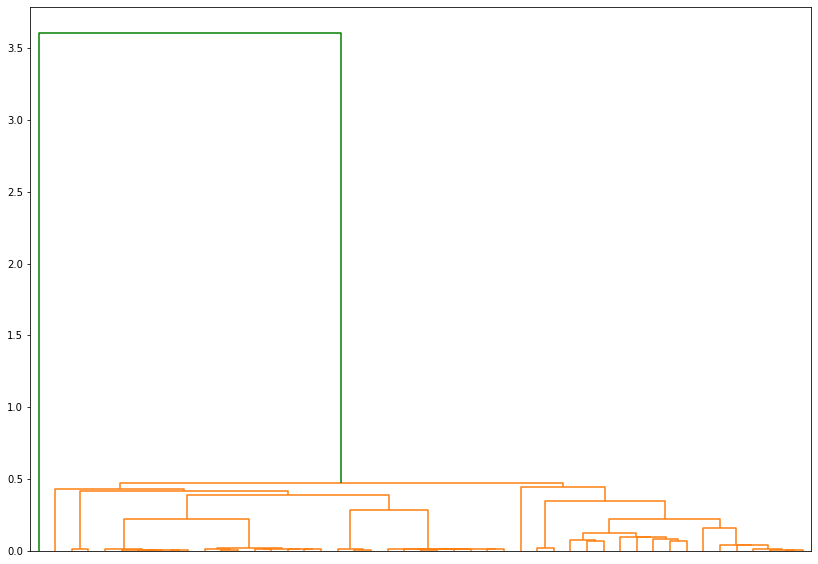

In [47]:
# Plot the cluster as a dendrogram.
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html
mfccs = mfccs[0:len(mfccs)-1]
temp = hierarchy.linkage(mfccs, 'single') # cluster the frames based on hierarchy

# create a dendrogram sorting the leaves by distance in ascending order
dn = hierarchy.dendrogram(
    temp, above_threshold_color="green", color_threshold=.7, no_labels=True, distance_sort=True)

leaves = dn.get('leaves') # get leaves

In [48]:
output = []
for leaf in leaves:
    if SMOOTHING:
        output = smoothcatenate(output, frames[leaf], width=SM_WIDTH, sigma=SIGMA)
    else:
        output = np.concatenate([output, frames[leaf]])

ipd.Audio(output, rate=sr)

(292, 13)


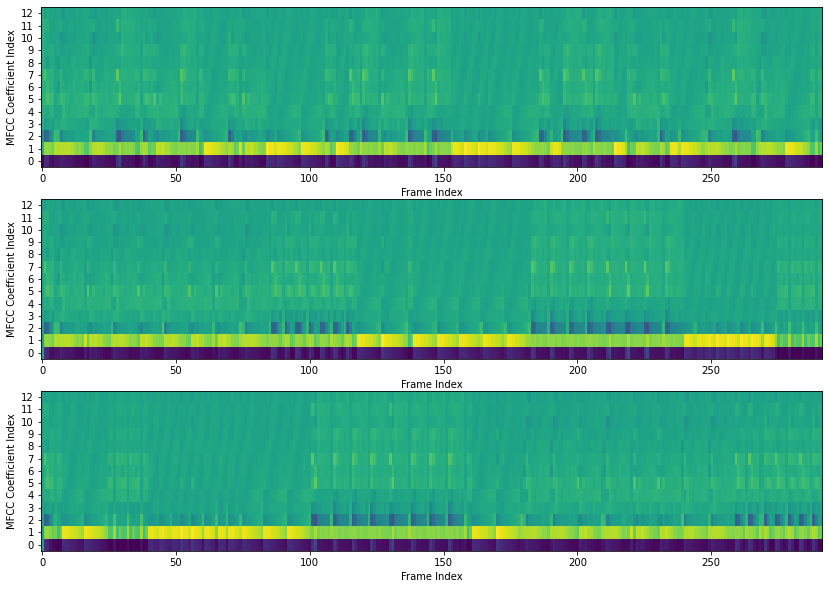

In [49]:
frames_3 = librosa.util.frame(output, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T
if WINDOWING:
    frames_3 = applyWindow(frames=frames_3, onset_detection=ONSET_DETECTION)
mfccs_3 = slideMFCC(frames=frames_3, zeroth_feature=ZEROTH_FEATURE)

plt.subplot(3, 1, 1)
displayMFCCS(mfccs=mfccs_0, zeroth_feature=ZEROTH_FEATURE)
plt.subplot(3, 1, 2)
displayMFCCS(mfccs=mfccs_1, zeroth_feature=ZEROTH_FEATURE)
plt.subplot(3, 1, 3)
displayMFCCS(mfccs=mfccs_3, zeroth_feature=ZEROTH_FEATURE)

At last, we can also save the output into a file:

In [50]:
## Uncomment the line below to save
# sf.write("output.wav", output, sr)